This notebook solves the cell tracking issue by using [SAM2](https://github.com/facebookresearch/segment-anything-2/tree/main) instead of the functionality within CellProfiler.
Here I use the pretrained model to segment the nuclei in the video.
The output is a mask for each object in each frame and the x,y coordinates centers of each object in each frame.

This is a notebook that needs perfect conditions to work. 
With a GeForce RTX 3090 TI, the 24GB of VRAM sometimes are not enough to process the videos.

Hold your breath, pick a four-leaf clover, avoid black cats, cracks, and mirrors, and let's go!

This notebook is converted to a script and ran from script to be compatible with HPC cluster.

# Table of Contents for this Notebook
#### 1. Imports
#### 2. Import data
#### 3. get the masks and centers
#### 4. Track multiple objects in the video
#### 5. Track the objects through frames
#### 6. Visualize the tracking and output the data

## 1. Imports

In [1]:
# top level imports
import argparse
import gc  # garbage collector
import logging  # logging
import pathlib  # path handling
import shutil  # file handling
import subprocess  # subprocess handling
import sys  # system

import lancedb  # lancedb database
import matplotlib.pyplot as plt  # plotting
import numpy as np  # numerical python
import pandas as pd  # data handling
import pyarrow as pa  # pyarrow for parquet
import torch  # pytorch deep learning
import tqdm  # progress bar
from csbdeep.utils import Path, normalize  # dependecy for stardist
from PIL import Image  # image handling
from sam2.build_sam import build_sam2, build_sam2_video_predictor  # sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor  # sam2 image predictor
from skimage import io  # image handling
from skimage.measure import label, regionprops  # coordinate handling
from skimage.transform import resize  # image handling

sys.path.append("../../utils/")
from SAM2_utils import (  # sam2 utils
    delete_recorded_memory_history,
    export_memory_snapshot,
    generate_random_coords,
    show_mask,
    show_points,
    start_record_memory_history,
    stop_record_memory_history,
)

# check cuda devices
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
0
1
NVIDIA GeForce RTX 3090 Ti


In [2]:
# # import the arguments
# parser = argparse.ArgumentParser(description="Process timelapse images.")
# parser.add_argument(
#     "--model_to_use",
#     type=str,
#     default="all",
#     help="Options: all, tiny, small, base, large",
# )
# parser.add_argument(
#     "--downscale_factor", type=int, default=1, help="Downsample factor for images"
# )

# parser.add_argument(
#     "--downscale", action="store_true", help="Downsample the images before processing"
# )

# # get the arguments
# args = parser.parse_args()

# model_to_use = args.model_to_use
# downscale_factor = args.downscale_factor
# downscale = args.downscale

model_to_use = "tiny"
downscale_factor = 10

## 2. Import data

### Download the model(s)

In [3]:
models_dict = {
    "tiny": {
        "model_path": "sam2_hiera_tiny.pt",
        "model_link": "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt",
        "model_cfg": "sam2_hiera_t.yaml",
    },
    "small": {
        "model_path": "sam2_hiera_small.pt",
        "model_link": "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt",
        "model_cfg": "sam2_hiera_s.yaml",
    },
    "base": {
        "model_path": "sam2_hiera_base_plus.pt",
        "model_link": "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt",
        "model_cfg": "sam2_hiera_b+.yaml",
    },
    "large": {
        "model_path": "sam2_hiera_large.pt",
        "model_link": "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt",
        "model_cfg": "sam2_hiera_l.yaml",
    },
}

In [4]:
# Download the file using wget
# this is the model checkpoint for the SAM2 model
for model in models_dict.keys():
    model_path = pathlib.Path(models_dict[model]["model_path"]).resolve()
    new_model_path = pathlib.Path("../../data/models").resolve() / model_path.name
    # check if the model already exists
    if not new_model_path.exists():
        subprocess.run(["wget", models_dict[model]["model_link"]], check=True)
        new_model_path.parent.mkdir(parents=True, exist_ok=True)
        shutil.move(model_path, new_model_path)
    else:
        print(f"Model {new_model_path} already exists. Skipping download.")

if model_to_use == "tiny":
    sam2_checkpoint = pathlib.Path("../../data/models/sam2_hiera_tiny.pt").resolve()
    model_cfg = "sam2_hiera_t.yaml"
elif model_to_use == "small":
    sam2_checkpoint = pathlib.Path("../../data/models/sam2_hiera_small.pt").resolve()
    model_cfg = "sam2_hiera_s.yaml"
elif model_to_use == "base":
    sam2_checkpoint = pathlib.Path(
        "../../data/models/sam2_hiera_base_plus.pt"
    ).resolve()
    model_cfg = "sam2_hiera_b+.yaml"
elif model_to_use == "large":
    sam2_checkpoint = pathlib.Path("../../data/models/sam2_hiera_large.pt").resolve()
    model_cfg = "sam2_hiera_l.yaml"
else:
    exception_message = (
        f"Model {model_to_use} not found. Please choose from: tiny, small, base, large"
    )

Model /home/lippincm/Documents/live_cell_timelapse_apoptosis/data/models/sam2_hiera_tiny.pt already exists. Skipping download.
Model /home/lippincm/Documents/live_cell_timelapse_apoptosis/data/models/sam2_hiera_small.pt already exists. Skipping download.
Model /home/lippincm/Documents/live_cell_timelapse_apoptosis/data/models/sam2_hiera_base_plus.pt already exists. Skipping download.
Model /home/lippincm/Documents/live_cell_timelapse_apoptosis/data/models/sam2_hiera_large.pt already exists. Skipping download.


In [5]:
# set the path to the videos
sam2_processing_dir = pathlib.Path(
    f"../sam2_processing_dir/{model_to_use}_model_{downscale_factor}x_factor/"
).resolve()
sam2_processing_dir.mkdir(parents=True, exist_ok=True)
ordered_tiffs = pathlib.Path(sam2_processing_dir / "tiffs/").resolve()
converted_to_video_dir = pathlib.Path(sam2_processing_dir / "pngs/").resolve()
if converted_to_video_dir.exists():
    shutil.rmtree(converted_to_video_dir)

ordered_tiffs.mkdir(parents=True, exist_ok=True)
converted_to_video_dir.mkdir(parents=True, exist_ok=True)

In [6]:
tiff_dir = pathlib.Path("../../2.cellprofiler_ic_processing/illum_directory/").resolve(
    strict=True
)
jpeg_dir = pathlib.Path("../stardist_processing_dir/10x_factor/jpegs/").resolve(
    strict=True
)
star_dist_dir = pathlib.Path(
    f"../stardist_processing_dir/{downscale_factor}x_factor/star_dist_masks/"
).resolve(strict=True)

## 3. Get initial masks and centers via StarDist

### Get the first frame of each video
### Set up a dict that holds the images path, the first frame_mask, and the first frame_centers

### Plot the segementation
Plot the following:
- the original image
- the segmentation
- the x,y centers of the segmentation
- the extracted masks

In [7]:
star_dist_files = {
    "context_dir": [],
    "first_frame_image": [],
    "coords_file": [],
    "image_x_y_coords": [],
    "image_labels": [],
}

# get a list of dirs in the star dist directory
star_dist_dirs = list(star_dist_dir.glob("*"))
star_dist_dirs = sorted(star_dist_dirs)
jpeg_dirs = list(jpeg_dir.glob("*"))
jpeg_dirs = sorted(jpeg_dirs)
for key, dir in enumerate(star_dist_dirs[:1]):
    # get the files in the directory
    files = sorted(dir.glob("*.jpeg"))
    star_dist_files["context_dir"].append(jpeg_dirs[key])
    star_dist_files["first_frame_image"].append(files[0])
coords_path = pathlib.Path(
    f"../stardist_processing_dir/{downscale_factor}x_factor/star_dist_coords/"
).resolve()
coords_dirs = list(coords_path.glob("*"))
coords_dirs = sorted(coords_dirs)
for dir in coords_dirs[:1]:
    # get the files in the directory
    files = sorted(dir.glob("*.parquet"))
    star_dist_files["coords_file"].append(files[0])
star_dist_files

{'context_dir': [PosixPath('/home/lippincm/Documents/live_cell_timelapse_apoptosis/3b.run_sam/stardist_processing_dir/10x_factor/jpegs/C-02_F0001')],
 'first_frame_image': [PosixPath('/home/lippincm/Documents/live_cell_timelapse_apoptosis/3b.run_sam/stardist_processing_dir/10x_factor/star_dist_masks/C-02_F0001/001.jpeg')],
 'coords_file': [PosixPath('/home/lippincm/Documents/live_cell_timelapse_apoptosis/3b.run_sam/stardist_processing_dir/10x_factor/star_dist_coords/C-02_F0001/001_coords.parquet')],
 'image_x_y_coords': [],
 'image_labels': []}

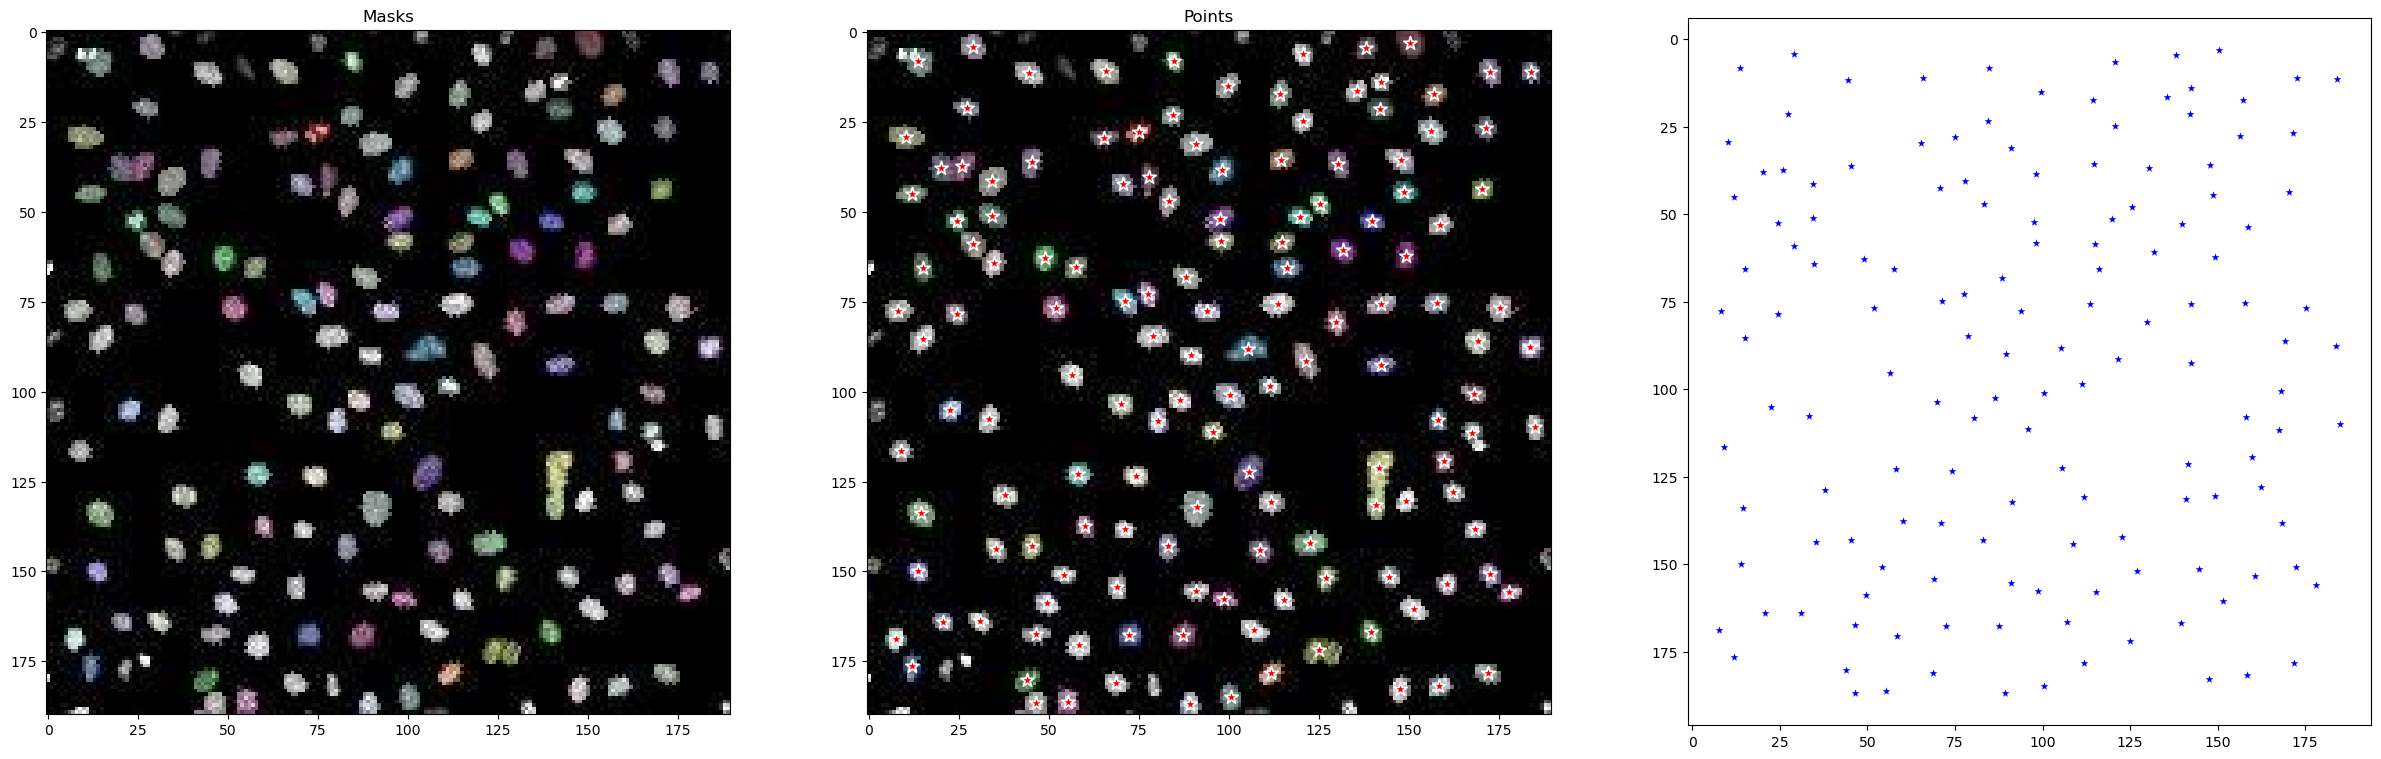

In [8]:
visualize = True
for context_dir, first_frame, coords_file in zip(
    star_dist_files["context_dir"],
    star_dist_files["first_frame_image"],
    star_dist_files["coords_file"],
):
    # print(mask_dir, first_frame)
    img = io.imread(first_frame)
    coords_df = pd.read_parquet(coords_file)
    coords = coords_df[["x", "y"]].values
    # plot the points and the masks and the image side by side by side
    fig, ax = plt.subplots(1, 3, figsize=(30, 15))
    ax[0].imshow(img)
    ax[0].set_title("Masks")
    ax[1].imshow(img, cmap="gray")
    ax[1].scatter(
        coords[:, 0],
        coords[:, 1],
        color="red",
        marker="*",
        s=100,
        edgecolor="white",
        linewidth=1.25,
    )
    ax[1].set_title("Points")

    ax[2].invert_yaxis()
    # make the aspect ratio equal
    ax[2].set_aspect("equal")
    show_points(coords, np.ones(len(coords)), ax[2])
    labels = np.ones(coords.shape[0], dtype=np.int32)
    star_dist_files["image_x_y_coords"].append(coords)
    star_dist_files["image_labels"].append(labels)

In [9]:
# remove all stardist gpu memory
torch.cuda.empty_cache()

Each of the below cells need to be run on the HPC cluster.
My local machine does not have enough memory to run the below cells.

## 4. Track multiple objects in the video

### Begin GPU Profiling

In [10]:
# Start recording memory snapshot history
logging.basicConfig(
    format="%(levelname)s:%(asctime)s %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger: logging.Logger = logging.getLogger(__name__)
logger.setLevel(level=logging.INFO)

TIME_FORMAT_STR: str = "%b_%d_%H_%M_%S"
# delete any prior memory profiling data
delete_recorded_memory_history(
    logger=logger,
    save_dir=pathlib.Path(
        f"../memory_snapshots/{model_to_use}_model_{downscale_factor}x_factor/"
    ).resolve(),
)

# Keep a max of 100,000 alloc/free events in the recorded history
# leading up to the snapshot.
MAX_NUM_OF_MEM_EVENTS_PER_SNAPSHOT: int = 10000000000
start_record_memory_history(
    logger=logger, max_entries=MAX_NUM_OF_MEM_EVENTS_PER_SNAPSHOT
)

INFO:2025-03-10 21:44:04 Deleted memory snapshot file: /home/lippincm/Documents/live_cell_timelapse_apoptosis/3b.run_sam/memory_snapshots/tiny_model_10x_factor
INFO:2025-03-10 21:44:04 Starting snapshot record_memory_history


In [11]:
# clear the memory
torch.cuda.empty_cache()
gc.collect()

107

In [12]:
stored_video_segments = {}

In [13]:
# loop through each image set and predict the instances
for i in range(len(star_dist_files["context_dir"])):
    torch.cuda.empty_cache()
    predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint)
    print(star_dist_files["context_dir"][i])
    first_frame_name = star_dist_files["first_frame_image"][i]
    img = io.imread(first_frame_name)
    h, w, _ = img.shape
    # all frames
    frame_files = sorted(star_dist_files["context_dir"][i].glob("*"))
    # initialize the state
    inference_state = predictor.init_state(
        video_path=str(star_dist_files["context_dir"][i]),
        # offload_video_to_cpu=True,  # set to True if the video is too large to fit in GPU memory
        # offload_state_to_cpu=True,  # set to True if the state is too large to fit in GPU memory
    )
    predictor.reset_state(inference_state)
    prompts = {}
    ann_frame_idx = 0
    ann_obj_idx = 1
    samples = 1
    negative_sampling = (
        False  # set True to generate negative samples for better training
    )
    # loop through the points and add them to the state and get the masks
    for _point, _label in zip(
        star_dist_files["image_x_y_coords"][i], star_dist_files["image_labels"][i]
    ):
        _label = np.array([_label], dtype=np.int32)
        _point = np.array([_point], dtype=np.float32)
        if negative_sampling:
            random_points, random_labels = generate_random_coords(
                img=img, coords=_point, samples=samples
            )
            _point = np.concatenate([_point, random_points], axis=0)
            _label = np.concatenate([_label, random_labels], axis=0)
        # add the points to the state
        _, out_obj_ids, out_mask_logits = predictor.add_new_points(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=ann_obj_idx,
            points=_point,
            labels=_label,
        )
        # save the prompts
        prompts[ann_obj_idx] = {
            "points": _point,
            "labels": _label,
            "out_obj_ids": out_obj_ids[0],
            "out_mask_logits": out_mask_logits[0].detach().cpu().numpy(),
        }
        # increment the object index for this frame
        ann_obj_idx += 1

    del prompts
    del samples
    # run propagation throughout the video and collect the results in a dict
    video_segments = {}  # video_segments contains the per-frame segmentation results

    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(
        inference_state
    ):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(range(1, ann_obj_idx))
        }
        stored_video_segments[star_dist_files["context_dir"][i]] = video_segments

    # clear the memory
    del inference_state

    del out_mask_logits
    del out_obj_ids
    del out_frame_idx
    torch.cuda.empty_cache()
    gc.collect()

INFO:2025-03-10 21:44:04 Loaded checkpoint sucessfully


/home/lippincm/Documents/live_cell_timelapse_apoptosis/3b.run_sam/stardist_processing_dir/10x_factor/jpegs/C-02_F0001


propagate in video:   8%|▊         | 1/13 [00:00<00:04,  2.52it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 9.00 GiB. GPU 0 has a total capacity of 23.55 GiB of which 7.65 GiB is free. Including non-PyTorch memory, this process has 14.59 GiB memory in use. Of the allocated memory 13.56 GiB is allocated by PyTorch, and 739.26 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### stop GPU profiling

In [ ]:
# save the memory snapshot to a file
export_memory_snapshot(
    logger=logger,
    save_dir=pathlib.Path(
        f"../memory_snapshots/{model_to_use}_model_{downscale_factor}x_factor/"
    ).resolve(),
)
stop_record_memory_history(logger=logger)

In [49]:
# remove previous runs generated files
# each of these directories will be created if they do not exist
# the new files will be saved in these directories

# for masks
masks_dir = pathlib.Path(sam2_processing_dir / "masks").resolve()
if masks_dir.exists():
    shutil.rmtree(masks_dir)
masks_dir.mkdir(exist_ok=True, parents=True)

# for gifs
gifs_dir = pathlib.Path(sam2_processing_dir / "gifs").resolve()
if gifs_dir.exists():
    shutil.rmtree(gifs_dir)
gifs_dir.mkdir(exist_ok=True, parents=True)

# for combined masks and tiffs
combined_dir = pathlib.Path(sam2_processing_dir / "CP_input").resolve()
if combined_dir.exists():
    shutil.rmtree(combined_dir)
combined_dir.mkdir(exist_ok=True, parents=True)

In [50]:
output_dict = {
    "image_set_name": [],
    "frame": [],
    "object_id": [],
    "x": [],
    "y": [],
    "mask_path": [],
    "mask_file_name": [],
}

In [51]:
# loop through each image set and save the predicted masks as images
for i in range(len(star_dist_files["image_set_name"])):
    print(
        f"{star_dist_files['image_set_name'][i]}: {star_dist_files['image_set_first_frame'][i]}"
    )
    frame_names = sorted(
        list(Path(star_dist_files["image_set_path"][i]).glob("*.jpeg"))
    )
    img = io.imread(frame_names[0])
    h, w = img.shape
    upscale_h = h * downscale_factor
    upscale_w = w * downscale_factor
    print(h, w, "upscaled", upscale_h, upscale_w)
    # add all of the frames together for a rendered gif
    # create a list of all the frames
    frames = []

    video_segments = stored_video_segments[star_dist_files["image_set_name"][i]]
    for out_frame_idx in range(0, len(frame_names), 1):
        # create a figure
        # set the frame path and make the directory if it doesn't exist
        # create a frame image
        frame_image = np.zeros((h, w), dtype=np.uint8)
        # loop through the objects in the frame
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            # add the mask to the frame image
            frame_image += (out_mask[0] * 255).astype(np.uint8)
            out_mask = np.array(out_mask[0], dtype=np.float32)
            # convert the outmask to an image
            regions = regionprops(label(out_mask))
            for region in regions:
                y, x = region.centroid
                # scale the x and y coordinates back to the original size
                x = x * downscale_factor
                y = y * downscale_factor
                output_dict["frame"].append(out_frame_idx)
                output_dict["object_id"].append(out_obj_id)
                output_dict["x"].append(x)
                output_dict["y"].append(y)
                output_dict["mask_file_name"].append(f"{out_frame_idx}.png")
                output_dict["image_set_name"].append(
                    star_dist_files["image_set_name"][i]
                )
                output_dict["mask_path"].append(masks_dir)

        # save the frame image
        # scale the image upscale back to the original size
        frame_image = Image.fromarray(frame_image)
        frame_image = frame_image.resize((upscale_w, upscale_h), Image.NEAREST)

        # convert the frame image to ints
        frame_image_path = f"{masks_dir}/{star_dist_files['image_set_name'][i]}_T{str(out_frame_idx + 1).zfill(4)}_Z0001_mask.png"
        frame_image.save(frame_image_path)

        # add title to the subplot
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        # show the image
        ax.imshow(frame_image, cmap="gray")
        ax.set_title(f"Frame {out_frame_idx}")
        # save the figure to a file
        tmpdir = pathlib.Path(
            sam2_processing_dir / f"tmp_{out_frame_idx}.png"
        ).resolve()
        fig.savefig(tmpdir)
        # close the figure
        plt.close(fig)
        # open the image
        img = Image.open(tmpdir)
        # append the image to the frames
        frames.append(img)

    fig_path = pathlib.Path(
        f"{gifs_dir}/{star_dist_files['image_set_name'][i]}_out.gif"
    ).resolve()
    # save the frames as a gif
    frames[0].save(
        fig_path, save_all=True, append_images=frames[1:], duration=10, loop=0
    )

    # get all files that have tmp in the name
    tmp_files = list(tmpdir.glob("tmp*.png"))
    # delete all the tmp files
    [f.unlink() for f in tmp_files]

In [52]:
file_paths_df = pd.DataFrame(output_dict)
# add the mask file path
file_paths_df["mask_file_path"] = (
    file_paths_df["mask_path"].astype(str)
    + "/"
    + file_paths_df["mask_file_name"].astype(str)
)
# type cast the columns
file_paths_df["image_set_name"] = file_paths_df["image_set_name"].astype(str)
file_paths_df["frame"] = file_paths_df["frame"].astype(np.int32)
file_paths_df["object_id"] = file_paths_df["object_id"].astype(np.int32)
file_paths_df["x"] = file_paths_df["x"].astype(np.float32)
file_paths_df["y"] = file_paths_df["y"].astype(np.float32)
file_paths_df["mask_path"] = file_paths_df["mask_path"].astype(str)
file_paths_df["mask_file_name"] = file_paths_df["mask_file_name"].astype(str)
file_paths_df["mask_file_path"] = file_paths_df["mask_file_path"].astype(str)

In [53]:
file_paths_df_write_path = pathlib.Path(
    f"{sam2_processing_dir}/object_coords/"
).resolve()
file_paths_df_write_path.mkdir(parents=True, exist_ok=True)
file_paths_df_write_path = file_paths_df_write_path / "object_coords.parquet"
file_paths_df.to_parquet(file_paths_df_write_path)